In [ ]:
from google.colab import drive
drive.mount("/drive")

Mounted at /drive


In [ ]:
import pandas as pd
from matplotlib import pyplot as plt

import numpy as np
import cv2
import math
from google.colab.patches import cv2_imshow
from scipy.signal import find_peaks
from scipy import signal
import skimage.measure 

In [ ]:
file_name = '/drive/MyDrive/Roopsa Sen/Raw Data/TOFD3.xlsx'
sheet = 'TOFD3'
df = pd.read_excel(io=file_name, sheet_name=sheet)
df = df[df.iloc[:,1] != '---']
df = df.astype(float)
#print(df.head(5)) 
im_arr = df.to_numpy()

In [ ]:
im_arr = cv2.normalize(im_arr, None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)
im_arr = im_arr.astype(np.uint8)

In [ ]:
file_name = '/drive/MyDrive/Roopsa Sen/Raw Data/A_scans/2485.txt'
A_scan = pd.read_csv(file_name, sep=" ", header=None)
A_scan.columns = ['sample', 'index', 'value']
A_scan['value'] = A_scan.value.str[7:-1].apply(pd.to_numeric)


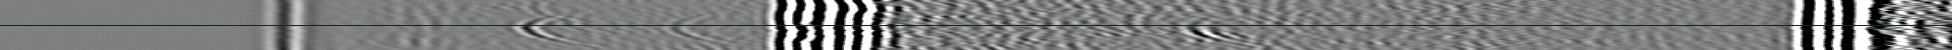

In [ ]:
scan_x = 2485
img_original = im_arr[scan_x - 25:scan_x + 25, :]
img = cv2.cvtColor(im_arr[scan_x - 25:scan_x + 25, :],cv2.COLOR_GRAY2RGB)
img = cv2.line(img, (0, 25), (2500,25), [255,0,0], 1)
cv2_imshow(img)


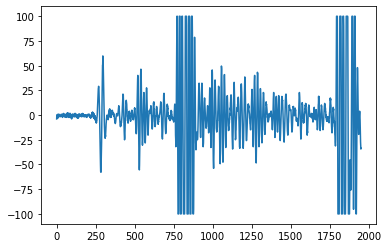

In [ ]:
A_scan['value'].plot()

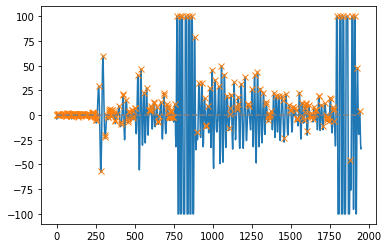

In [ ]:
x = A_scan['value']
peaks, _ = find_peaks(x)
plt.plot(x)
plt.plot(peaks, x[peaks], "x")
plt.plot(np.zeros_like(x), "--", color="gray")
plt.show()

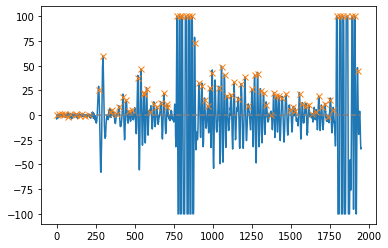

In [ ]:
peaks = signal.find_peaks_cwt(x, np.arange(1,10))
plt.plot(x)
plt.plot(peaks, x[peaks], "x")
plt.plot(np.zeros_like(x), "--", color="gray")
plt.show()

In [ ]:
def hl_envelopes_idx(s, dmin=1, dmax=1, split=False):
    """
    Input :
    s: 1d-array, data signal from which to extract high and low envelopes
    dmin, dmax: int, optional, size of chunks, use this if the size of the input signal is too big
    split: bool, optional, if True, split the signal in half along its mean, might help to generate the envelope in some cases
    Output :
    lmin,lmax : high/low envelope idx of input signal s
    """

    # locals min      
    lmin = (np.diff(np.sign(np.diff(s))) > 0).nonzero()[0] + 1 
    # locals max
    lmax = (np.diff(np.sign(np.diff(s))) < 0).nonzero()[0] + 1 
    

    if split:
        # s_mid is zero if s centered around x-axis or more generally mean of signal
        s_mid = np.mean(s) 
        # pre-sorting of locals min based on relative position with respect to s_mid 
        lmin = lmin[s[lmin]<s_mid]
        # pre-sorting of local max based on relative position with respect to s_mid 
        lmax = lmax[s[lmax]>s_mid]

    # global max of dmax-chunks of locals max 
    lmin = lmin[[i+np.argmin(s[lmin[i:i+dmin]]) for i in range(0,len(lmin),dmin)]]
    # global min of dmin-chunks of locals min 
    lmax = lmax[[i+np.argmax(s[lmax[i:i+dmax]]) for i in range(0,len(lmax),dmax)]]
    
    return lmin,lmax

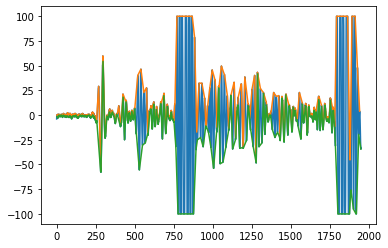

In [ ]:
low_idx, high_idx = hl_envelopes_idx(x, dmin = 1, dmax = 1)
plt.plot(x)
plt.plot(x[high_idx])
plt.plot(x[low_idx])

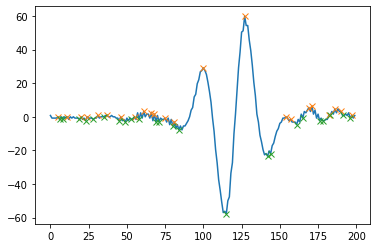

In [ ]:
lw_idx = high_idx[x[high_idx] > 25][0]
lw_idx_region = x[lw_idx - 100:lw_idx + 100].reset_index(drop=True)
plt.plot(lw_idx_region)
low_idx_lw, high_idx_lw = hl_envelopes_idx(lw_idx_region, dmin = 3, dmax = 3)

plt.plot(lw_idx_region[high_idx_lw], 'x')
plt.plot(lw_idx_region[low_idx_lw], 'x')

In [ ]:
high_idx_lw = high_idx_lw[lw_idx_region[high_idx_lw] > 15]
low_idx_lw = low_idx_lw[lw_idx_region[low_idx_lw] < -15]

lw_bound = []
if high_idx_lw[0] < low_idx_lw[0]:
  lw_bound.append(lw_idx - 100 + high_idx_lw[0])
  lw_bound.append(lw_idx - 100 + low_idx_lw[-1])

else:
  lw_bound.append(lw_idx - 100 + low_idx_lw[0])
  lw_bound.append(lw_idx - 100 + high_idx_lw[-1])

lw_bound

[269, 313]

In [ ]:
im_col = cv2.cvtColor(im_arr,cv2.COLOR_GRAY2RGB)
im_col = cv2.line(im_col, (lw_bound[0], 0), (lw_bound[0], im_arr.shape[0]), [255,0,0], 2)
im_col = cv2.line(im_col, (lw_bound[1], 0), (lw_bound[1], im_arr.shape[0]), [255,0,0], 2)
cv2_imshow(im_col)

In [ ]:
wavelets = pd.DataFrame(columns = ['high_idx', 'grp']) 
wavelets['high_idx'] = high_idx

In [ ]:
wavelets.iloc[38]['grp']

nan

In [ ]:
grp = 0
max_idx = 0
for idx in high_idx[x[high_idx] > 20]:
  current_idx = list(high_idx).index(idx)
  print("this is the index", current_idx, high_idx[current_idx])
  if max_idx <= current_idx:
    for i in range(current_idx, 0, -1):
      wavelets.iloc[i, wavelets.columns.get_loc('grp')] = grp
      if(x[high_idx[i]] < 0):
        break
    
    for i in range(current_idx, len(high_idx)):
      wavelets.iloc[i, wavelets.columns.get_loc('grp')] = grp
      max_idx = i
      if(x[high_idx[i]] < 0):
        break
    grp = grp+1
  print(grp)



this is the index 114 269
1
this is the index 116 296
2
this is the index 117 298
2
this is the index 152 425
3
this is the index 153 427
3
this is the index 173 520
4
this is the index 174 540
4
this is the index 175 559
4
this is the index 176 576
4
this is the index 201 686
5
this is the index 202 688
5
this is the index 225 771
6
this is the index 226 773
6
this is the index 227 786
6
this is the index 228 791
6
this is the index 229 802
6
this is the index 230 806
6
this is the index 231 825
6
this is the index 232 832
6
this is the index 233 846
6
this is the index 234 851
6
this is the index 235 864
6
this is the index 236 869
6
this is the index 237 884
6
this is the index 239 913
7
this is the index 240 931
7
this is the index 246 982
8
this is the index 247 997
8
this is the index 248 1015
8
this is the index 249 1016
8
this is the index 252 1038
9
this is the index 253 1040
9
this is the index 254 1056
9
this is the index 255 1075
9
this is the index 256 1076
9
this is the i

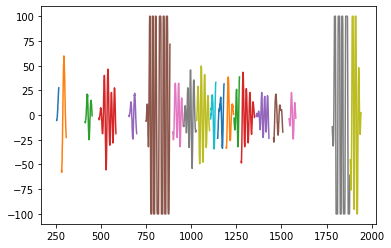

In [ ]:
wall_grps = []
for i in range(grp):
  low = wavelets.groupby(by = 'grp')['high_idx'].min()[i]
  high = wavelets.groupby(by = 'grp')['high_idx'].max()[i]

  if len(x[low:high][x[low:high] > 70]) > 0:
    wall_grps.append(i)

  plt.plot(x[low:high])


In [ ]:
wall_grps

[5, 17, 18]

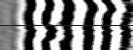

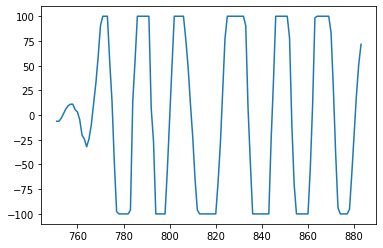

In [ ]:
low = wavelets.groupby(by = 'grp')['high_idx'].min()[5]
high = wavelets.groupby(by = 'grp')['high_idx'].max()[5]
plt.plot(x[low:high])
part = img[:, low:high]
cv2_imshow(part)

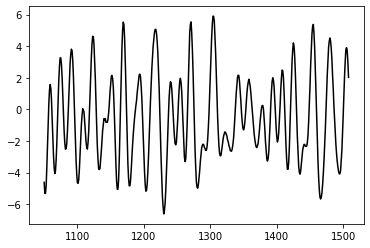

In [ ]:
smooth_data = pd.Series(x[low:high]).rolling(window=20).mean().plot(style='k')
plt.show()

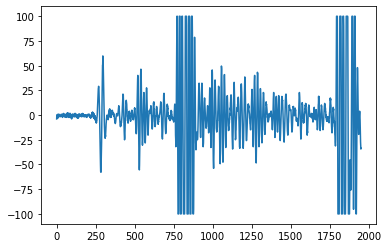

In [ ]:
plt.plot(x)

256
283
414


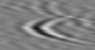

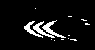

490
659
751


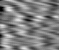

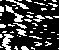

898
959
1031
1110
1154


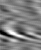

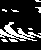

1195
1238
1278
1375
1457
1542
1782
1881


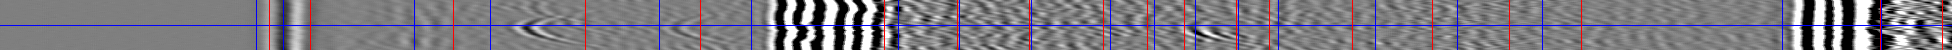

In [ ]:
scan_x = 2485
img_original = im_arr[scan_x - 25:scan_x + 25, :]
img = cv2.cvtColor(im_arr[scan_x - 25:scan_x + 25, :],cv2.COLOR_GRAY2RGB)
img = cv2.line(img, (0, 25), (2500,25), [255,0,0], 1)
for i in range(grp):
  low = wavelets.groupby(by = 'grp')['high_idx'].min()[i]
  high = wavelets.groupby(by = 'grp')['high_idx'].max()[i]
  part = img_original[:, low:high]

  im_thresh1 = cv2.inRange(part, 0, 80)
  im_thresh2 = cv2.inRange(part, 160, 255)
  im_thresh = cv2.bitwise_or(im_thresh1, im_thresh2)

  contours, hierarchy = cv2.findContours(im_thresh, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
  max_area = cv2.contourArea(max(contours, key = cv2.contourArea))
  if max_area > 50 and max_area < 300:
    cv2_imshow(part)
    cv2_imshow(im_thresh)
  print(low)
  img = cv2.line(img, (low, 0), (low, 50), [255, 0, 0], 1)
  img = cv2.line(img, (high, 0), (high, 50), [0, 0, 255], 1)
cv2_imshow(img)